## Plot sfincs_map.nc results

We use the [cartopy](https://scitools.org.uk/cartopy/docs/latest/) package to plot maps. This packages provides a simple interface to plot geographic data and add background satellite imagery.

In [1]:
# import dependencies
import xarray as xr
import numpy as  np
from os.path import join
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import hydromt

### Read model results

The model results in sfincs_map.nc are saved as in a staggered grid format, see [SGRID convention](https://publicwiki.deltares.nl/display/NETCDF/Deltares+proposal+for+Staggered+Grid+data+model+(SGRID)). Here we show how to retrieve the face values and translate the dimensions from node indices (m, n) to (x, y) coordinates in order to plot the results on a map.

In [2]:
sfincs_root = 'venice_200' # (relative) path to sfincs root
mod = hydromt.SfincsModel(sfincs_root, mode='r')

In [3]:
# read results 
ds_map = xr.open_dataset(join(mod.root, 'sfincs_map.nc'), chunks={'time':100})

# get values which are saved on cell faces
face_vars = [v for v in ds_map.data_vars if 'm' in ds_map[v].dims]
face_coords = {
    'x': xr.IndexVariable('x', ds_map['x'].isel(n=0).values),
    'y': xr.IndexVariable('y', ds_map['y'].isel(m=0).values)
}
encoding = {v :{'zlib': True} for v in face_vars}
ds_face = ds_map[face_vars].drop(['x', 'y']).rename({'n':'y', 'm':'x'}).assign_coords(face_coords).transpose('time', 'y', 'x', ...)
# set coordinate reference system based on epsg code in sfincs.inp > saved to spatial_ref coord
ds_face.raster.set_crs(mod.crs)
# inspect outcome
ds_face

<xarray.Dataset>
Dimensions:      (time: 25, x: 181, y: 145)
Coordinates:
  * time         (time) datetime64[ns] 2010-02-07 ... 2010-02-09
  * x            (x) float32 2.809e+05 2.811e+05 ... 3.167e+05 3.169e+05
  * y            (y) float32 5.03e+06 5.03e+06 5.03e+06 ... 5.059e+06 5.059e+06
    spatial_ref  int64 1
Data variables:
    msk          (y, x) float32 dask.array<chunksize=(145, 181), meta=np.ndarray>
    qinf         (y, x) float32 dask.array<chunksize=(145, 181), meta=np.ndarray>
    zb           (y, x) float32 dask.array<chunksize=(145, 181), meta=np.ndarray>
    zs           (time, y, x) float32 dask.array<chunksize=(25, 145, 181), meta=np.ndarray>
    h            (time, y, x) float32 dask.array<chunksize=(25, 145, 181), meta=np.ndarray>
    cuminf       (y, x) float32 dask.array<chunksize=(145, 181), meta=np.ndarray>
Attributes:
    Conventions:                         Conventions = 'CF-1.6, SGRID-0.3
    Build-Revision-Date-Netcdf-library:  4.6.1 of Mar 16 2018 14:16:08 $
    Producer:                            SFINCS model: Super-Fast INundation ...
    Build-Revision:                      $Rev: 220 $
    Build-Date:                          $Date: 2021-01-15$
    title:                               SFINCS map netcdf output

### Calculate hmax and mask with surface water mask

First we have to mask the water depth based on a map of permanent water which we calculate from the Global Surface Water Occurence (GSWO) dataset. 

In [4]:
# read global surface water occurance (GSWO) data to mask permanent water
print(mod.data_catalog['gswo'])
gswo = mod.data_catalog.get_rasterdataset('gswo', buffer=10)
# permanent water where water occurence > 5%
gswo_mask = gswo.raster.reproject_like(mod.staticmaps, method='max') <= 5

{'category': 'surface water',
 'data_type': 'RasterDataset',
 'driver': 'raster',
 'paper_doi': '10.1038/nature20584',
 'paper_ref': 'Pekel et al. (2016)',
 'path': '/home/runner/.hydromt_data/data/v0.0.4/gswo.tif',
 'source_url': 'https://global-surface-water.appspot.com/download',
 'source_version': 'v1_1_2019'}


In [5]:
hmin = 0.2 # minimum flood depth [m] to plot 
da_hmax = ds_face['h'].max('time') # get the maximum flood depth
# get overland flood depth with GSWO and set minimum flood depth
da_hmax_fld = da_hmax.where(gswo_mask).where(da_hmax>hmin)
# update attributes for colorbar label later
da_hmax_fld.attrs.update(long_name='flood depth', unit='m') 

### Plot maximum water depth

Here we plot the maximum water depth on top of the :py:meth:`~hydromt_sfincs.sfincs.SfincsModel.plot_basemaps` method.

No handles with labels found to put in legend.


Text(0.5, 1.0, 'SFINCS maximum water depth')

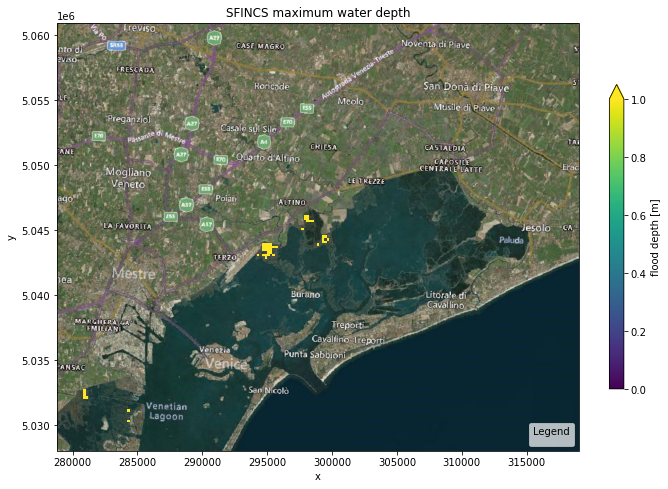

In [6]:
# create hmax plot and save to mod.root/figs/hmax.png
fig, ax = mod.plot_basemap(fn_out=None, variable=None, bmap='sat', geoms=['src', 'bnd'], figsize=(11,8))
# plot overland flooding based on gswo mask and mimum flood depth
cbar_kwargs = dict(aspect=20, fraction=.1, shrink=.7)
cax_fld = da_hmax_fld.plot(ax=ax, vmin=0, vmax=1.0, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs)

ax.set_title(f'SFINCS maximum water depth')
# plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")

### Animate water level

An animation is also simple to make with `matplotlib.animation` method. Here we add the surface water level in blue colors next to the overland flood depth with viridis colormap. 

In [7]:
# differentiate h inside and outside permanent water mask
da_h = ds_face['h'].where(gswo_mask)
da_h = da_h.where(da_h>hmin).drop('spatial_ref')
da_h.attrs.update(long_name='flood depth', unit='m')
da_zs = ds_face['zs'].where(~gswo_mask).drop('spatial_ref')
da_zs.attrs.update(long_name='surface water level', unit='m+MSL')

In [8]:
# create hmax plot and save to mod.root/figs/sfincs_h.mp4
# requires ffmpeg install with "conda install ffmpeg -c conda-forge"
from matplotlib import animation
step = 1 # one frame every <step> dtout

def update_plot(i, da_h, cax_h, da_zs=None, cax_zs=None):
    da_hi = da_h.isel(time=i)
    t = da_hi.time.dt.strftime("%d-%B-%Y %H:%M:%S").item()
    ax.set_title(f'SFINCS water depth {t}')
    cax_h.set_array(da_hi.values.ravel())
    if da_zs is not None and cax_zs is not None:
        da_zsi = da_zs.isel(time=i)
        cax_zs.set_array(da_zsi.values.ravel())

fig, ax = mod.plot_basemap(fn_out=None, variable=None, bmap='sat', geoms=['src', 'bnd'], figsize=(11, 8))
cax_h = da_h.isel(time=0).plot(ax=ax, vmin=0, vmax=1.0, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs)
cax_zs = da_zs.isel(time=0).plot(ax=ax, vmin=-1, vmax=1, cmap=plt.cm.Blues, cbar_kwargs=cbar_kwargs)
plt.close()  # to prevent double plot

ani = animation.FuncAnimation(
    fig,
    update_plot,
    frames=np.arange(0, da_h.time.size, step),
    interval=250,     # ms between frames
    fargs=(da_h, cax_h, da_zs, cax_zs)
)

# to save to mp4
# ani.save(join(mod.root, 'figs', 'sfincs_h.mp4'), fps=4, dpi=200)

# to show in notebook:
from IPython.display import HTML
HTML(ani.to_html5_video())

No handles with labels found to put in legend.
